In [2]:
import torch
import requests
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from lavis.common.gradcam import getAttMap
from lavis.models import load_model_and_preprocess

/home/ubuntu/anaconda3/envs/lavis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

What item s are spinning which can be used to control electric?


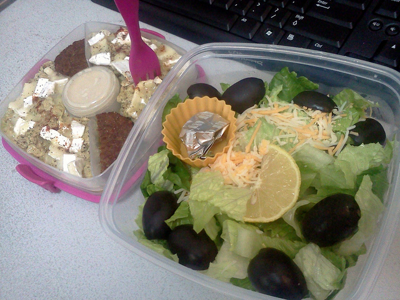

In [4]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/projects/pnp-vqa/demo.png'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# raw_image = Image.open("./demo.png").convert("RGB")
question = "What item s are spinning which can be used to control electric?"
print(question)
display(raw_image.resize((400, 300)))

In [5]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="img2prompt_vqa", model_type="base", is_eval=True, device=device)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
question = txt_processors["eval"](question)

samples = {"image": image, "text_input": [question]}

In [ ]:
samples = model.forward_itm(samples=samples)

In [ ]:
# Gradcam visualisation
dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255
gradcam = samples['gradcams'].reshape(24,24)

avg_gradcam = getAttMap(norm_img, gradcam, blur=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(avg_gradcam)
ax.set_yticks([])
ax.set_xticks([])
print('Question: {}'.format(question))

In [ ]:
samples = model.forward_cap(samples=samples, num_captions=50, num_patches=20)
print('Examples of question-guided captions: ')
samples['captions'][0][:5]

In [ ]:
samples = model.forward_qa_generation(samples)
print('Sample Question: {} \nSample Answer: {}'.format(samples['questions'][:5], samples['answers'][:5]))

In [ ]:
samples['questions']

In [ ]:
Img2Prompt = model.prompts_construction(samples)

In [ ]:
# In this notebook, we only use CPU for LLM inference
# To run inference on GPU, see https://github.com/CR-Gjx/Img2Prompt for reference
device = "cpu"

def postprocess_Answer(text):
    for i, ans in enumerate(text):
        for j, w in enumerate(ans):
            if w == '.' or w == '\n':
                ans = ans[:j].lower()
                break
    return ans

Img2Prompt_input = tokenizer(Img2Prompt, padding='longest', truncation=True, return_tensors="pt").to(device)

assert (len(Img2Prompt_input.input_ids[0])+20) <=2048

outputs_list  = []
outputs = llm_model.generate(input_ids=Img2Prompt_input.input_ids,
                         attention_mask=Img2Prompt_input.attention_mask,
                         max_length=20+len(Img2Prompt_input.input_ids[0]),
                         return_dict_in_generate=True,
                         output_scores=True
                         )
outputs_list.append(outputs)


In [ ]:
outputs_list

pred_answer = tokenizer.batch_decode(outputs.sequences[:, len(Img2Prompt_input.input_ids[0]):])
pred_answer = postprocess_Answer(pred_answer)

print({"question": question, "answer": pred_answer})

In [7]:
from lavis.models import model_zoo
print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xl_vitL, pretrain_flant5xxl, caption_coco_flant5xl
blip2_feature_extractor        pretrain, pretrain_vitL, coco
blip2                      

In [11]:
import torch
from PIL import Image
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load sample image
raw_image = Image.open("/home/ubuntu/LAVIS/docs/_static/merlion.png").convert("RGB")

: 